In [1]:
%load_ext autoreload
%autoreload 2

import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from tqdm import tqdm_notebook, tqdm

sys.path.append('../..')
from batchflow import Notifier, Pipeline, Dataset, I, W, V, L, B
from batchflow.monitor import *

In [2]:
BAR = 't' # can be changed to 'n' to use Jupyter Notebook progress bar

# Notifier

In [3]:
for item in Notifier(BAR)(range(10)):
    print(item)

100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 5102.56it/s]

0
1
2
3
4
5
6
7
8
9


In [4]:
%time for item in Notifier('t')(range(100000)): pass
%time for item in tqdm(range(100000)): pass

100%|██████████| 100000/100000 [00:00<00:00, 2831005.16it/s]

CPU times: user 254 ms, sys: 12.1 ms, total: 266 ms
Wall time: 264 ms
CPU times: user 39.1 ms, sys: 0 ns, total: 39.1 ms
Wall time: 38.4 ms


In [5]:
%time for item in Notifier('n')(range(100000)): pass
%time for item in tqdm_notebook(range(100000)): pass



CPU times: user 449 ms, sys: 23.6 ms, total: 473 ms
Wall time: 466 ms



CPU times: user 77.2 ms, sys: 5.47 ms, total: 82.7 ms
Wall time: 80.1 ms


# Monitors

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.01it/s]


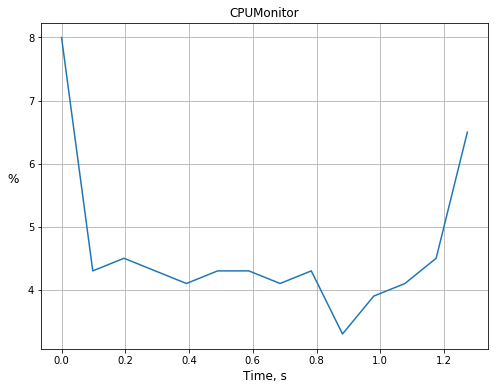

In [6]:
with monitor_cpu(frequency=0.1) as cpu_monitor:
    for _ in Notifier(BAR)(range(10)):
        _ = np.random.random((1000, 10000))
        
cpu_monitor.visualize()

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.05it/s]


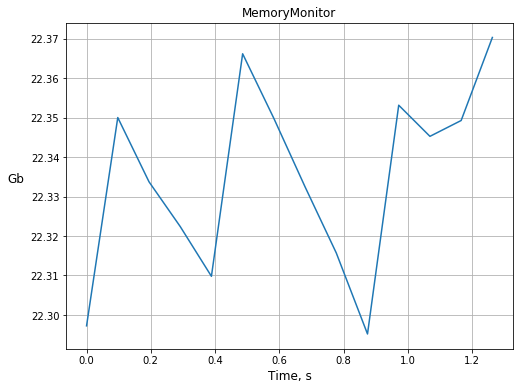

In [7]:
with monitor_memory(frequency=0.1) as memory_monitor:
    for _ in Notifier(BAR)(range(10)):
        _ = np.random.random((1000, 10000))
        
memory_monitor.visualize()

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.15it/s]


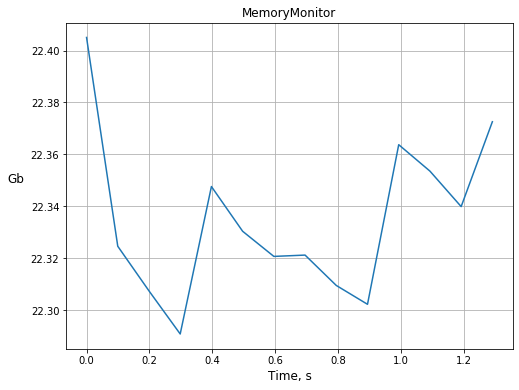

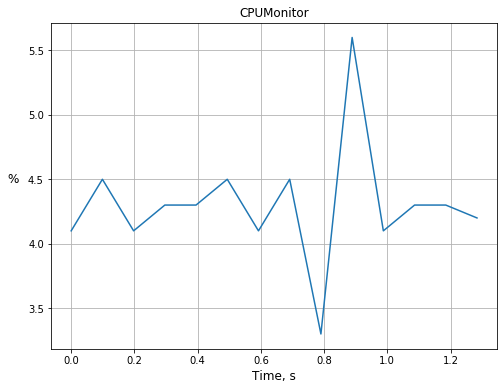

In [8]:
with monitor_resource(['memory', 'cpu'], frequency=0.1) as (memory_monitor, cpu_monitor):
    for _ in Notifier(BAR)(range(10)):
        _ = np.random.random((1000, 10000))
        
memory_monitor.visualize()
cpu_monitor.visualize()

In [9]:
notifier = Notifier(BAR, monitors=['memory', 'cpu'])

for _ in notifier(range(1000)):
    _ = np.random.random((1000, 100))
#     _ = np.random.random((1000, 10000))

100%|███████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 28.23it/s]


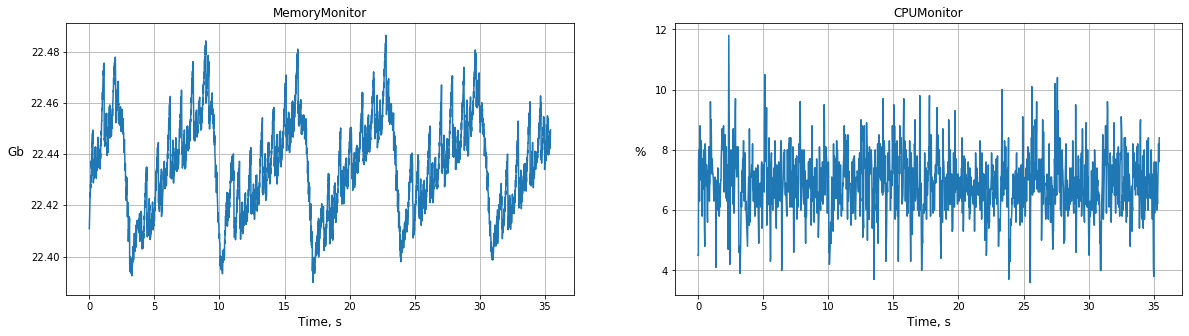

In [10]:
notifier.visualize()

# Pipeline

In [11]:
def foo(batch):
    batch.image = np.random.random((100, 100))


pipeline = (
    Pipeline()
    .init_variable('loss_history', [])
    .init_variable('image')

    .update(V('loss_history', mode='a'), 100 * 2 ** (-I()))
    .update(V('image'), L(np.random.random)((30, 30)))
    .foo(B())
) << Dataset(10)

## Vanilla pipeline
The easiest way to track progress is to supply argument `notifier` to the `run` method:
* 't' stands for simple text-based tqdm
* 'n' uses modern jupyter notebook bar
* an instance of `Notifier`
* dictionary with parameters of `Notifier` initialization

In [12]:
pipeline.reset('all')
_ = pipeline.run(1, n_iters=10, notifier=BAR)

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 102.31it/s]


## Track pipeline variables

We can use notifier to track values of pipeline variables at each iteration: conveniently, we use the same `monitor` argument:

In [13]:
pipeline.reset('all')
_ = pipeline.run(1, n_iters=10, notifier=Notifier(BAR, monitors='loss_history'))

loss_history=0.0976562: 100%|████████████████████████████| 10/10 [00:00<00:00, 846.05it/s]


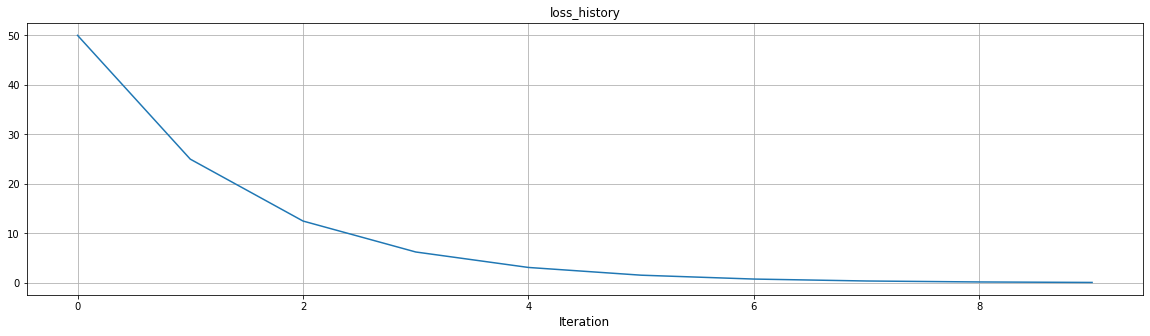

In [14]:
pipeline.notifier.visualize()

Obviously, we can use the same resource monitors, as before, by passing additional items to `monitors`. There is also `file` argument, that allows us to log the progress to storage:

In [15]:
pipeline.reset('all')
_ = pipeline.run(1, n_iters=50, notifier=Notifier(BAR, monitors=['cpu', 'loss_history'], file='notifications.txt'))

loss_history=8.88178e-14: 100%|█████████████████████████████████████| 50/50 [00:00<00:00, 51.36it/s]


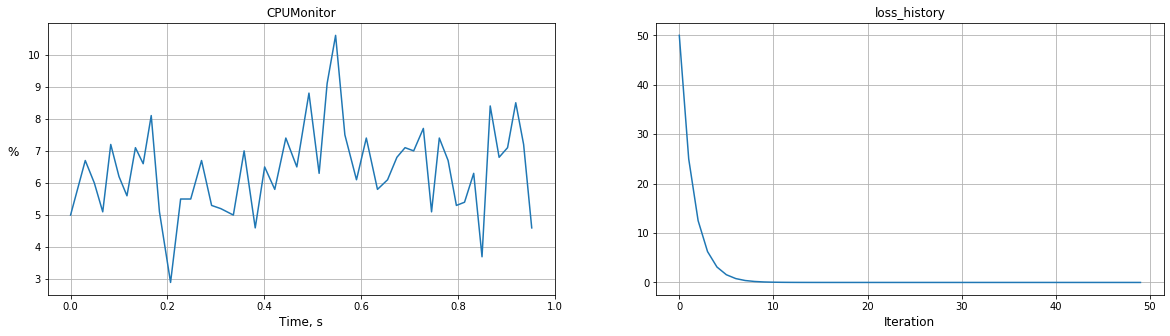

In [16]:
pipeline.notifier.visualize()

In [17]:
!head notifications.txt -n 20

2020-08-07  21:28:30     Iteration     0;    loss_history=50.0  
2020-08-07  21:28:30     Iteration     1;    loss_history=25.0  
2020-08-07  21:28:30     Iteration     2;    loss_history=12.5  
2020-08-07  21:28:30     Iteration     3;    loss_history=6.25  
2020-08-07  21:28:30     Iteration     4;    loss_history=3.125 
2020-08-07  21:28:30     Iteration     5;    loss_history=1.5625
2020-08-07  21:28:30     Iteration     6;    loss_history=0.78125
2020-08-07  21:28:30     Iteration     7;    loss_history=0.390625
2020-08-07  21:28:31     Iteration     8;    loss_history=0.195312
2020-08-07  21:28:31     Iteration     9;    loss_history=0.0976562
2020-08-07  21:28:31     Iteration    10;    loss_history=0.0488281
2020-08-07  21:28:31     Iteration    11;    loss_history=0.0244141
2020-08-07  21:28:31     Iteration    12;    loss_history=0.012207
2020-08-07  21:28:31     Iteration    13;    loss_history=0.00610352
2020-08-07  21:28:31     Iteration    14;    loss_history=0.00305176
2

## Live plots

One of the distinct features of `Notifier` is its ability of plotting data on the fly: to do so, we must supply `graphs` argument. Its semantics are exactly the same as those of `monitors` parameter.

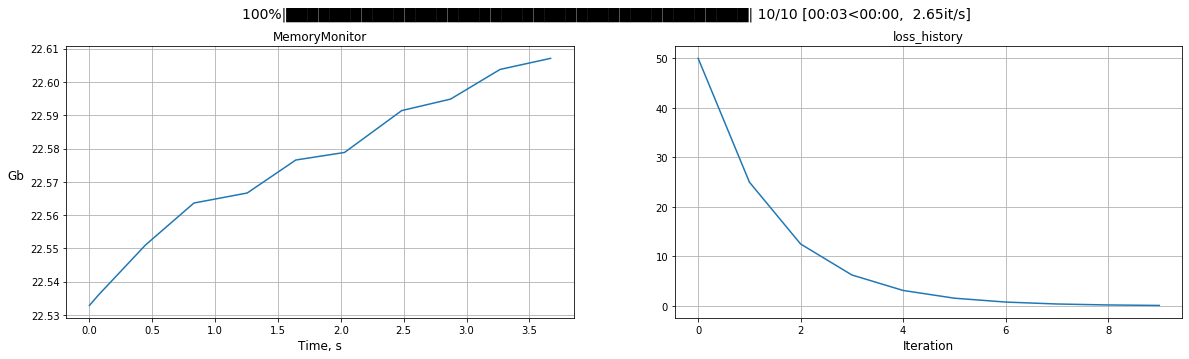

In [18]:
pipeline.reset('all')
_ = pipeline.run(1, n_iters=10, notifier=Notifier('n', graphs=['memory', 'loss_history']))

It can work with images also. As the rendering of plots might take some time, we want to do so once every 10 iterations and achieve so by using `frequency` parameter:

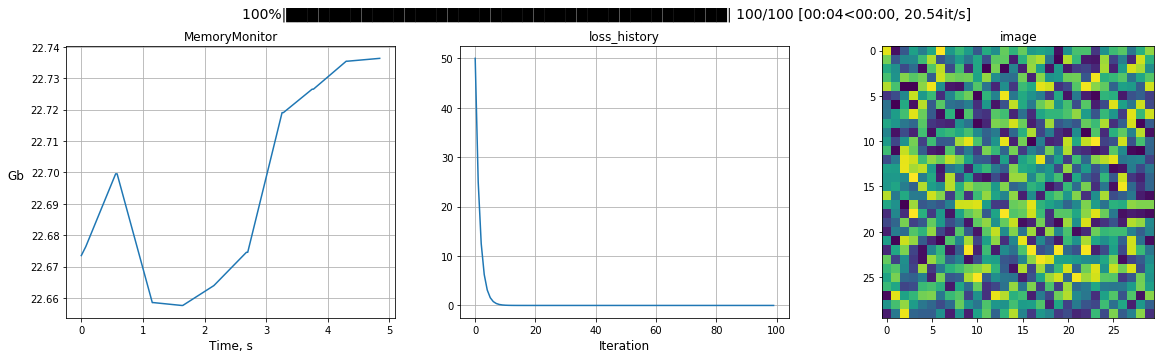

In [19]:
pipeline.reset('all')
_ = pipeline.run(1, n_iters=100, notifier=Notifier('n', graphs=['memory', 'loss_history', 'image'], frequency=10))

## Advanced usage of Notifier



In [20]:
def custom_plotter(ax=None, container=None, **kwargs):
    container['data'][10:20, 10:20] = 0
    
    ax.imshow(container['data'])
    ax.set_title(container['name'], fontsize=18)
    
    ax.set_xlabel('axis one', fontsize=18)
    ax.set_ylabel('axis two', fontsize=18)

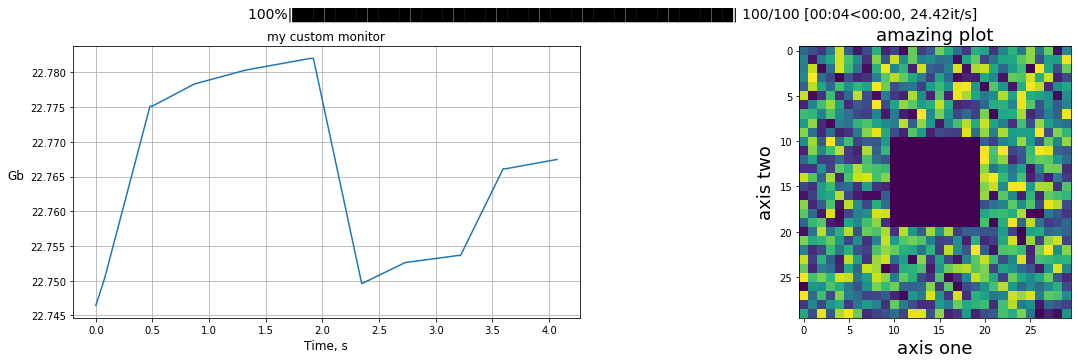

In [21]:
pipeline.reset('all')
_ = pipeline.run(1, n_iters=100,
                 notifier=Notifier('n',
                                   graphs=[{'source': 'memory',
                                            'name': 'my custom monitor'},
                                           {'source': 'image',
                                            'name': 'amazing plot',
                                            'plot_function': custom_plotter}],
                                   frequency=10)
                 )